In [91]:
using AlgebraicPetri, DataFrames, DifferentialEquations, ModelingToolkit, Symbolics, EasyModelAnalysis, Catlab, Catlab.CategoricalAlgebra, JSON3, UnPack, Downloads, URIs, CSV, MathML, NLopt, Plots, StatsPlots, OptimizationBBO, QuasiMonteCarlo
@info "usings"
MTK = ModelingToolkit
EMA = EasyModelAnalysis
meqs = MTK.equations
dd = "/Users/anand/.julia/dev/EasyModelAnalysis/data"

ArgumentError: ArgumentError: Package QuasiMonteCarlo not found in current path.
- Run `import Pkg; Pkg.add("QuasiMonteCarlo")` to install the QuasiMonteCarlo package.

In [92]:
include("demo_functions.jl")

build_weighted_ensemble_df (generic function with 1 method)

1. Upload a ground-truth dataset and its documentation via a URL
    * https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth-Incident%20Hospitalizations.csv
    * https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/README.md 

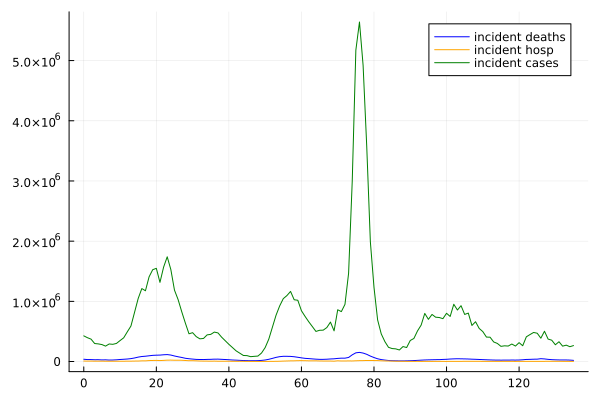

In [93]:
df, dfc, dfd, dfh, covidhub = get_dataframes()
plot_covidhub(df)

2. Split the dataset into a list of sub-datasets covering time periods of interest (in weeks)
    * select_timeperiods(df::DataFrame)::Vector{DataFrame}}


In [94]:
N_weeks = 20; period_step = 10; train_weeks=10
all_ts = df.t
dfs = select_timeperiods(df, N_weeks; step=period_step)
split_dfs = [train_test_split(df; train_weeks=train_weeks) for df in dfs]
train_dfs, test_dfs = unzip(split_dfs)

(DataFrame[10×4 DataFrame
 Row │ t      cases   deaths  hosp  
     │ Int64  Int64   Int64   Int64 
─────┼──────────────────────────────
   1 │     0  426504   38039   7823
   2 │     1  396061   32638   7369
   3 │     2  372155   32164   7097
   4 │     3  299096   29605   6046
   5 │     4  292841   30061   6228
   6 │     5  281799   26604   5821
   7 │     6  256026   28030   5071
   8 │     7  291617   24191   5275
   9 │     8  286018   25358   5347
  10 │     9  300436   28491   4953, 10×4 DataFrame
 Row │ t      cases   deaths  hosp  
     │ Int64  Int64   Int64   Int64 
─────┼──────────────────────────────
   1 │     5  281799   26604   5821
   2 │     6  256026   28030   5071
   3 │     7  291617   24191   5275
   4 │     8  286018   25358   5347
   5 │     9  300436   28491   4953
   6 │    10  348113   33744   5113
   7 │    11  394038   37562   5144
   8 │    12  493557   41729   5863
   9 │    13  589923   48331   6133
  10 │    14  818658   59224   7558, 10×4 DataFrame


### Loading the Petri nets for our ensemble and converting them to ODESystems

In [95]:
petris, syss, defs = load_ensemble()
all_syms = [sys_syms(sys) for sys in syss]


3-element Vector{Vector{Any}}:
 [Susceptible(t), Infected(t), Diagnosed(t), Ailing(t), Recognized(t), Healed(t), Threatened(t), Extinct(t), t1, t2  …  tau, delta, lambda, beta, eta, kappa, nu, epsilon, theta, sigma]
 [Susceptible(t), Exposed(t), Infectious(t), Asymptomatic(t), Hospitalized(t), Recovered(t), Deceased(t), t1, t2, t3  …  ModelValue_125, ModelValue_120, ModelValue_18, ModelValue_135, ModelValue_17, ModelValue_124, beta_1_USA, l_1_USA, ModelValue_5, ModelValue_13]
 [Susceptible_unconfined(t), Exposed(t), Infected_reported(t), Infected_unreported(t), Quarantined(t), Recovered(t), Deceased(t), t1, t2, t3  …  mu, h, q, lambda, f, beta, eta_u, eta_r, sigma, theta]

### Adjust all model defaults to be standardized to population, not proportion of population, then convert to simulatable ODEProblems

In [96]:
# adjust the defaults to be in terms of the total population. now all 3 models have defaults in terms of pop
# this is a weak link in the workflow
# TODO: scale the outputs for loss instead of the u0
total_pop = 300_000_000

global opt_step_count = 0
for i in 1:2 # only the first two are in proportions 
    for st in states(syss[i])
        defs[i][st] *= total_pop # this mutates the return of ModelingToolkit.defaults
    end
end

In [97]:
observed.(syss)

3-element Vector{Vector{Equation}}:
 [Deaths(t) ~ Extinct(t), Hospitalizations(t) ~ Recognized(t) + Threatened(t), Cases(t) ~ Diagnosed(t) + Hospitalizations(t)]
 [Cases(t) ~ Infectious(t), Hospitalizations(t) ~ Hospitalized(t), Deaths(t) ~ Deceased(t)]
 [Cases(t) ~ Infected_reported(t), Deaths(t) ~ Deceased(t), Hospitalizations(t) ~ h*Infected_reported(t)]

3. Generate model-model and model-dataset alignment/map during structural comparisons
    * e.g. {("model0.S", "model1.s", ...):  "dataset.feature0", ...} 
    * V{Tuple{V{State/Obs}, Symbol}}. Hosp, cases, 


Since the MiraNet schema encodes the observables (Cases, Deaths, Hospitalizations) uniformly through all models in the ensemble, we only need to provide a single list of Model observable => column name

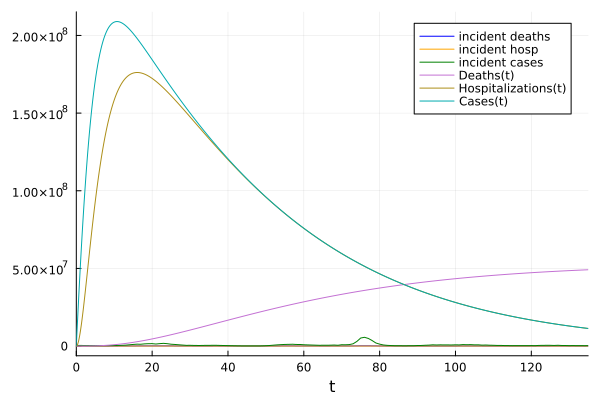

In [98]:
sys = syss[1]
syms = all_syms[1]

@unpack Deaths, Hospitalizations, Cases = sys
obs_sts = [Deaths, Hospitalizations, Cases]
mapping = Dict([Deaths => :deaths, Cases => :cases, Hospitalizations => :hosp])

prob = ODEProblem(sys, [], extrema(all_ts))
sol = solve(prob)
plt = plot_covidhub(df)
plot!(plt, sol; idxs=obs_sts)

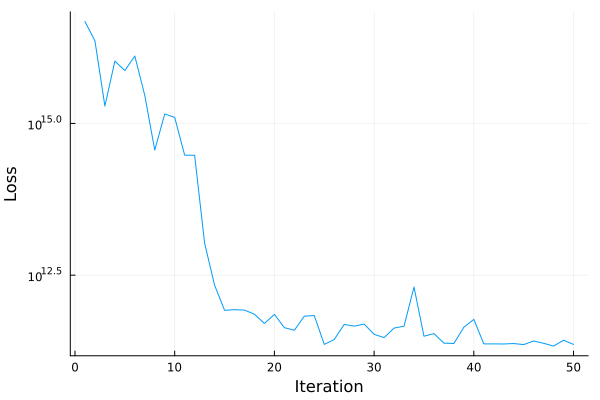

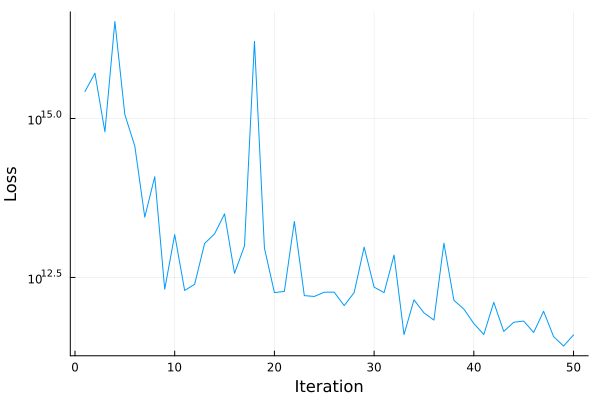

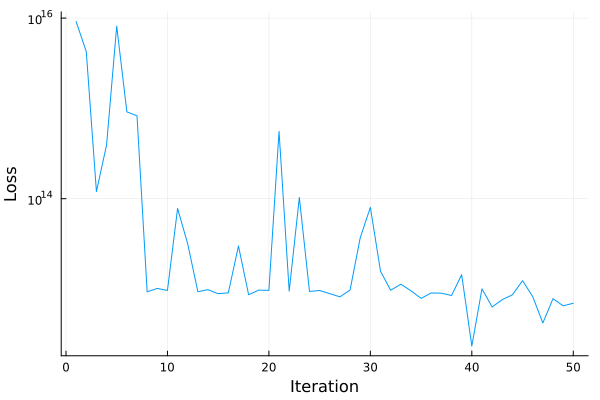

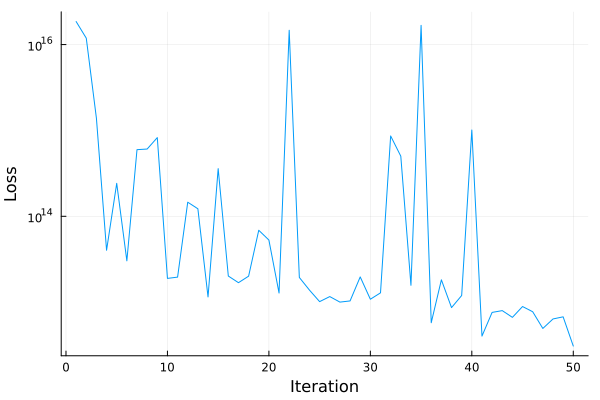

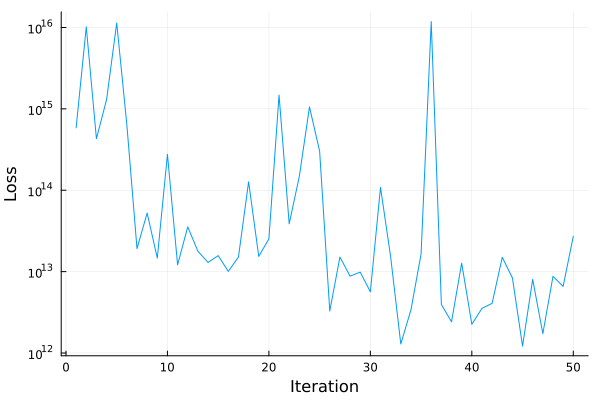

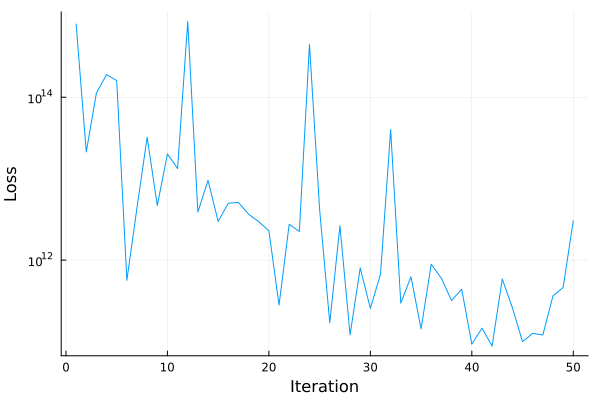

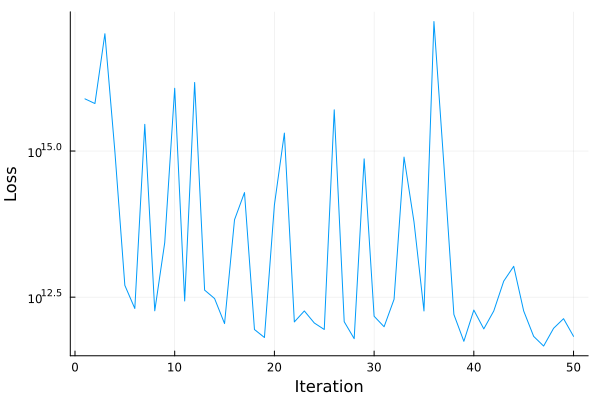

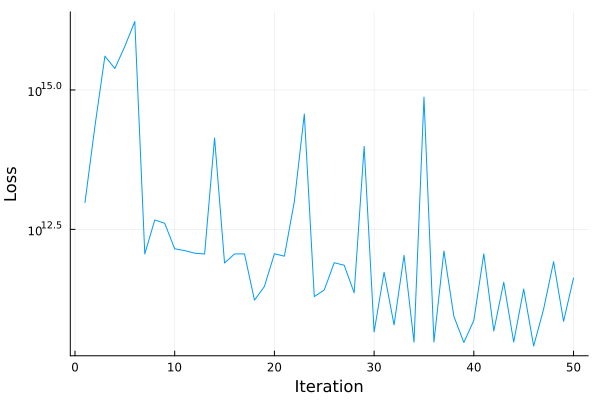

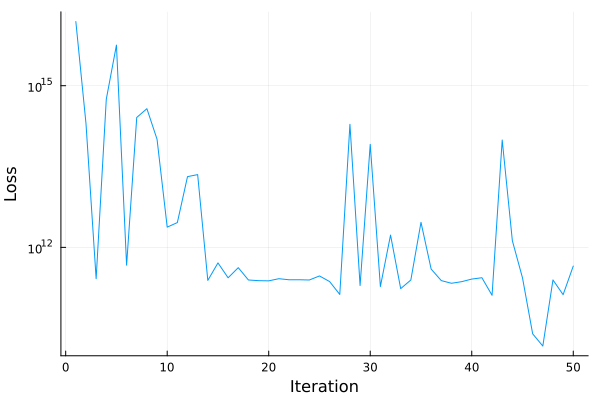

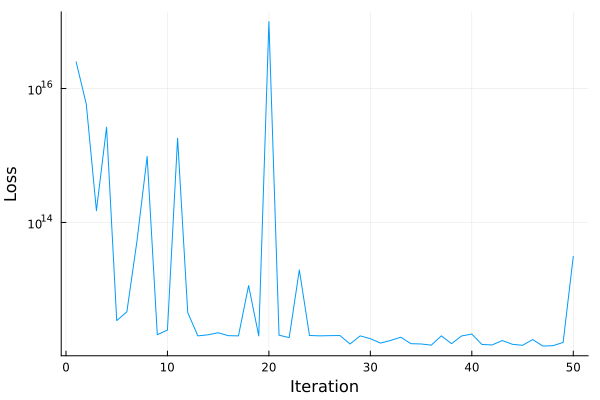

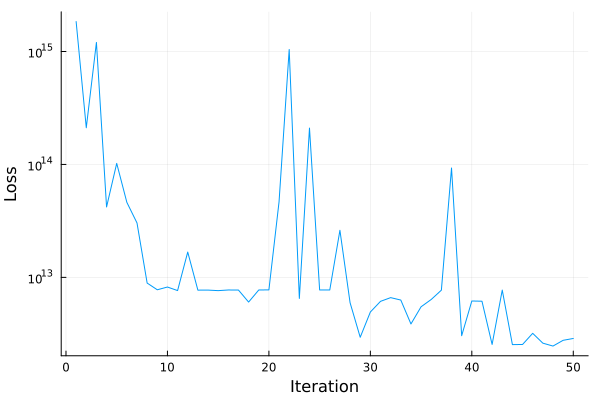

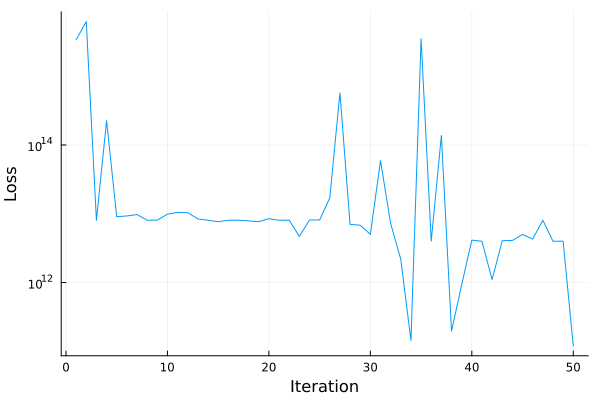

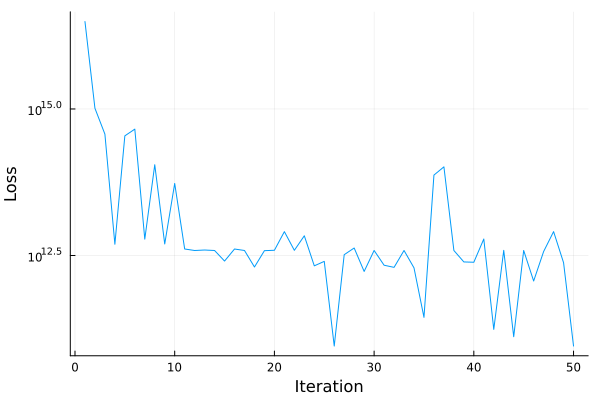

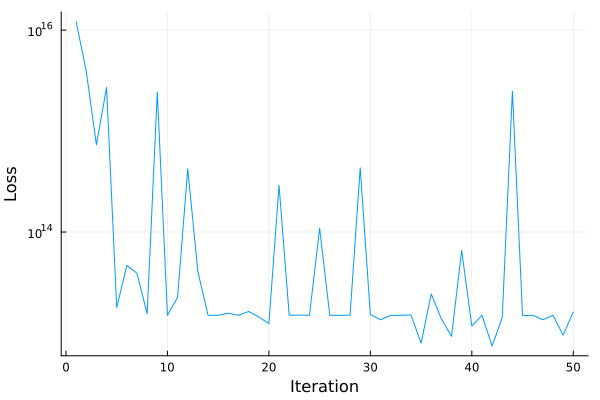

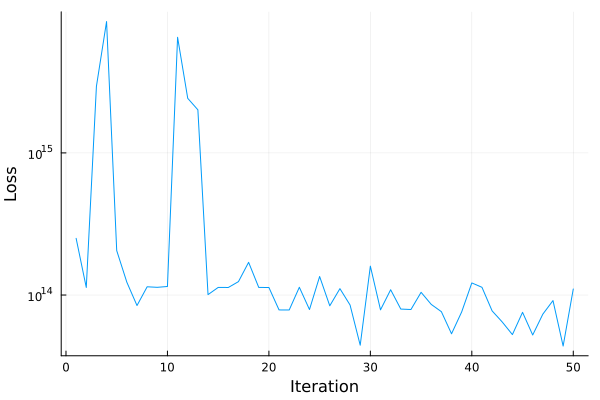

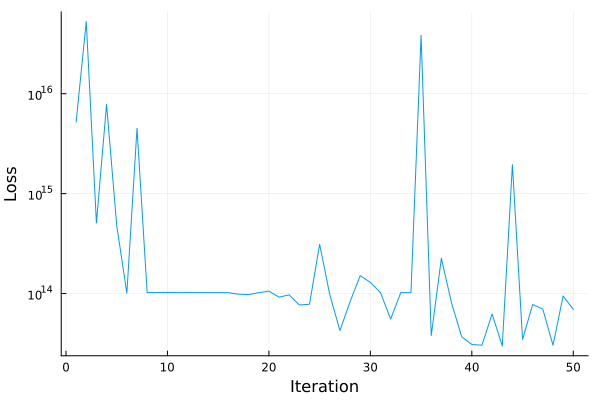

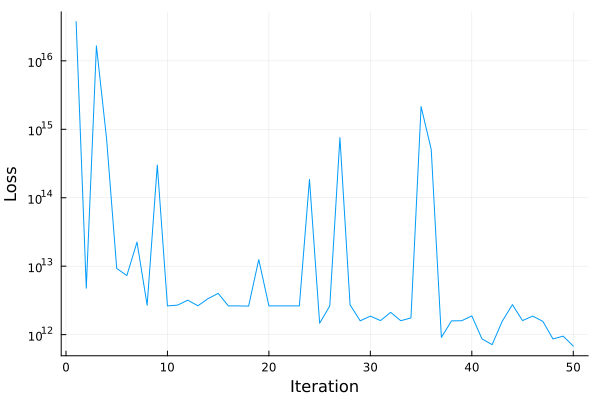

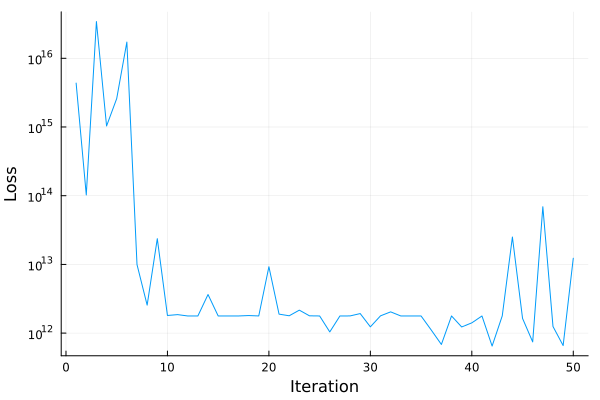

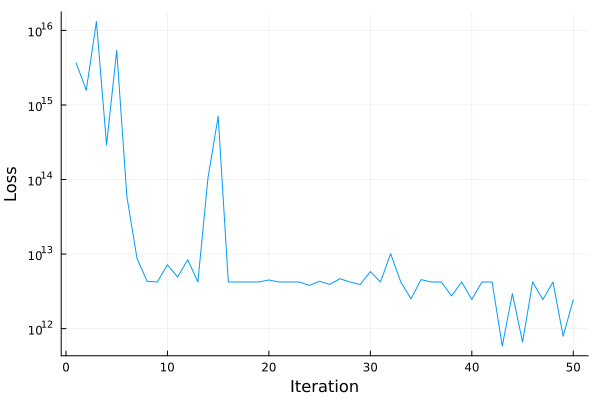

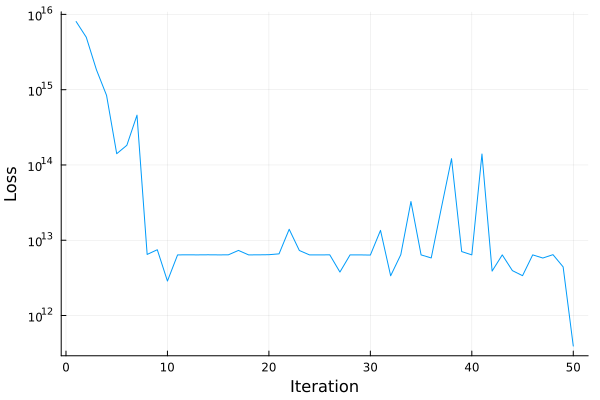

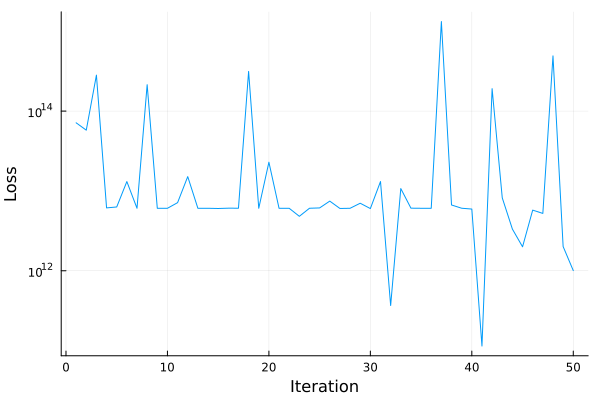

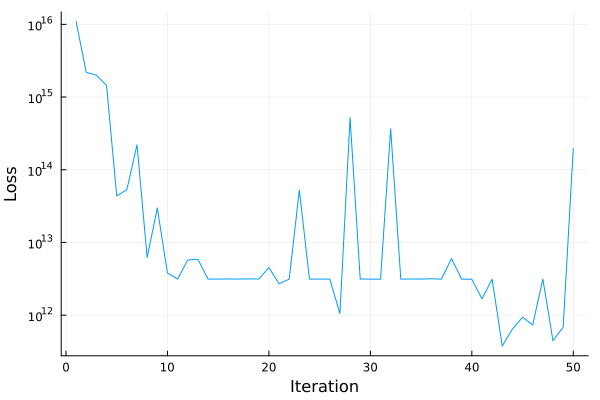

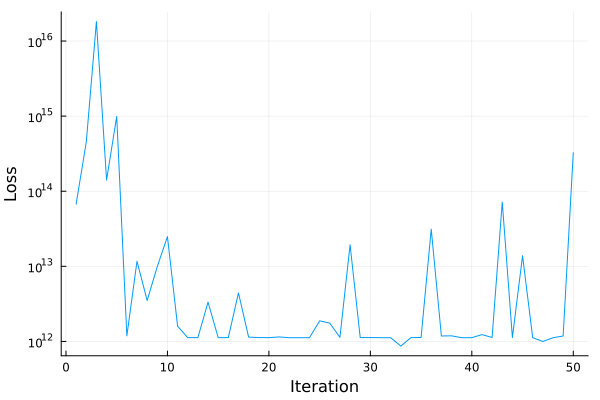

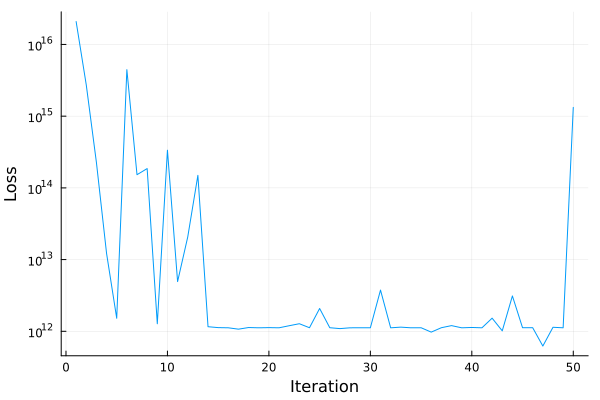

1-element Vector{Any}:
 Any[retcode: Failure
u: [7.894996540811843e7, 8.269304994504206e7, 9.96527571750489e7, 7.470092095659867e6, 9.50348124264881e7, 6.5650154997195385e7, 4.9962677609655395e7, 4.575911337326701e7, 0.11698391050552993, 0.502271453474189  …  0.5817407231656261, 0.979318691675678, 0.33631404866875647, 0.34712322875915735, 0.7182882245071944, 0.6087475214456122, 0.21254338607701928, 0.36533826679581355, 0.5753686732264067, 0.6218101644856135]
Final objective value:     2.1411031773691473e11
, retcode: Failure
u: [9.782312444393517e7, 5.185433140942283e7, 3.1210471218701094e7, 9.144826561034274e7, 4.021454580150291e7, 9.602972419615366e7, 7.93017246397689e7, 9.942752872100082e7, 0.8361147127190667, 0.916345366440084  …  0.9070762187336574, 0.34863366012321373, 0.35098194925917714, 0.05611090796419507, 0.0721769598038747, 0.0037516914446801553, 0.41656236350818643, 0.9117161861970791, 0.7023388387455095, 0.3149405722948394]
Final objective value:     2.6174000337474368e11

In [99]:
single_model_fits = global_ensemble_fit([prob], train_dfs, mapping; maxiters=5000);

4. Build an ensemble model using a list of the above models and alignment/map.
    * build_ensemble_model(Tuple{Vector<ODESystem>, typeof(3)})::EnsembleProblem | Vector{ODEProblem}


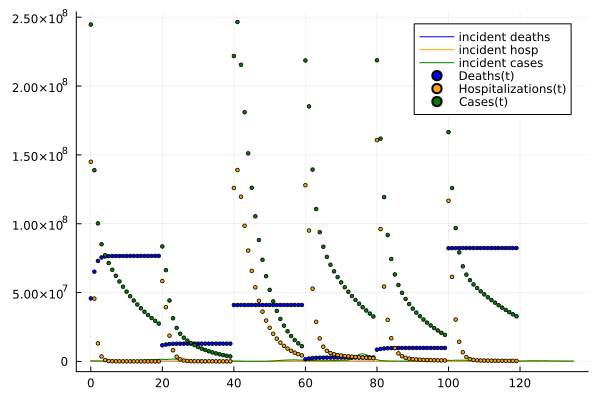

In [100]:
# TODO: to separate into train and test losses, i need to simulate train up until t0 of test, remake with that u0, then forecast for the test period
losses, remade_probs, remade_solutions = calculate_losses_and_solutions(single_model_fits, [prob], dfs);
fitdf = fitvec_to_df(single_model_fits[1], syms)
plt = forecast_plot(df, remade_solutions[1][1:2:end])

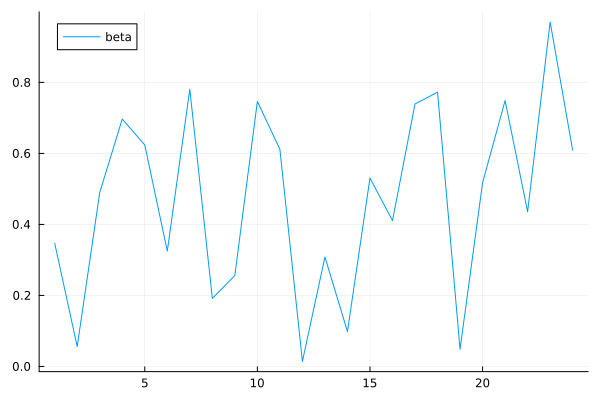

In [101]:
# plot how beta was fit for each timeperiod
plot(fitdf.beta; label="beta")

5. Build and run an ensemble calibration simulator 
    * Select the list of split ground-truth sub-datasets as training-test datasets
    * Select the ensemble model as the input model
    * Select the alignment/map
    * Specify the ensemble calibration mode (no-training-equal-weights, separate-model-weight training, joint model-weight training)
    * Specify the train-validate-test ratio, cross-validation mode, loss function, early-stop condition, etc.
    * ensemble_calibrate_separate(typeof(4), typeof(2)[1][1]; optimization_options)::V<(calibrationmap,loss,weights)>
    * Total 1-4. train 1-2, test 3-4. Trainloss = l2(1-2), testloss = l2(3-4)  


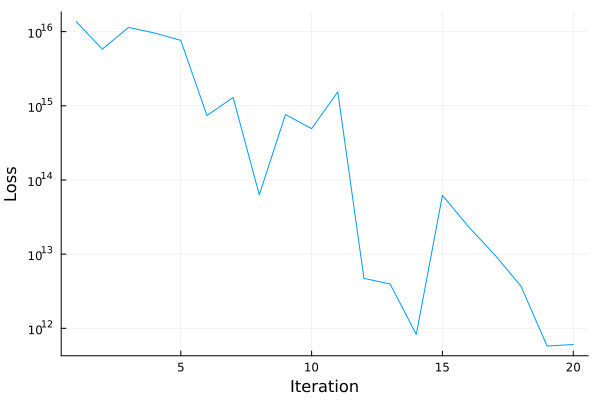

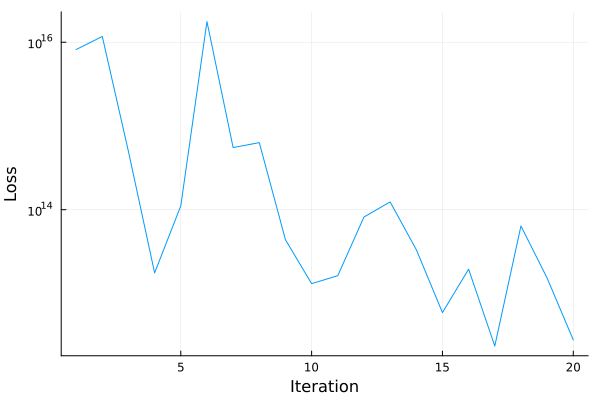

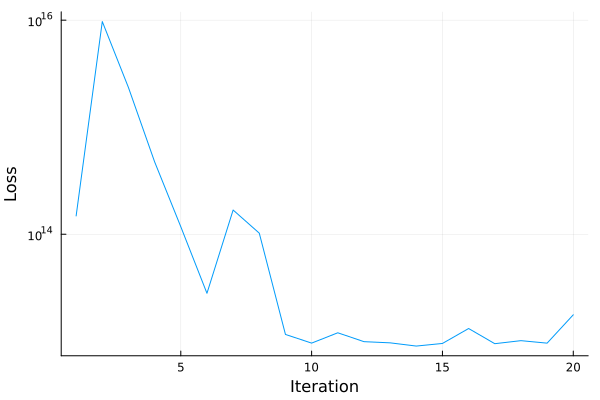

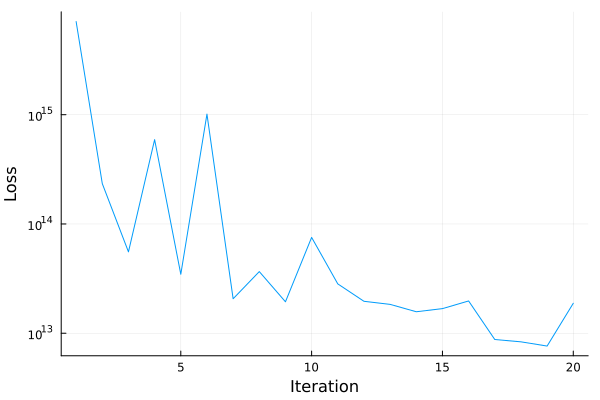

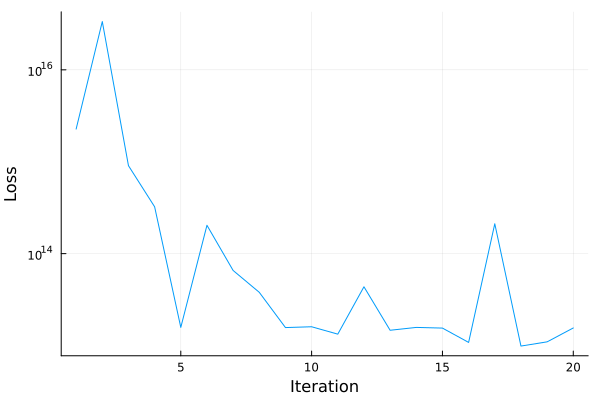

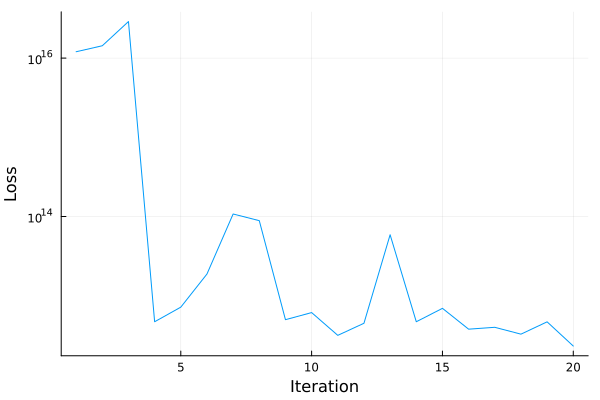

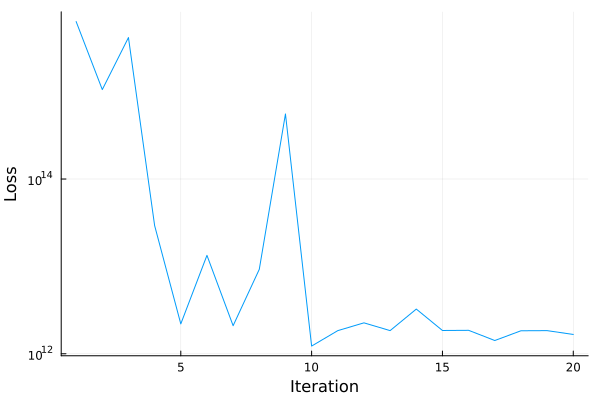

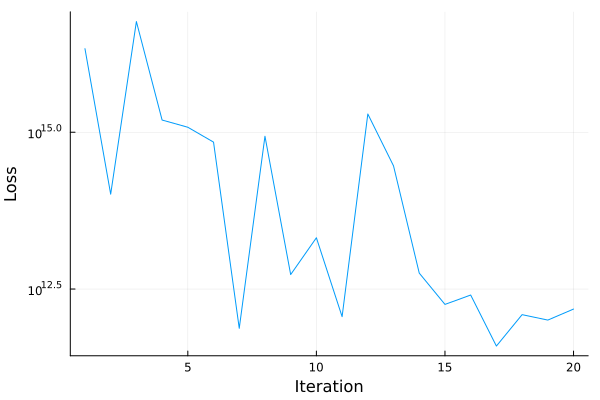

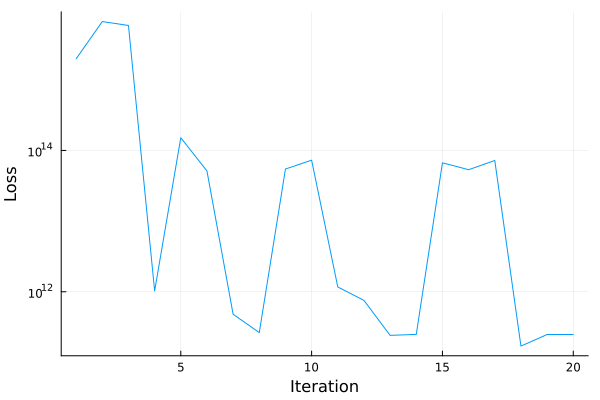

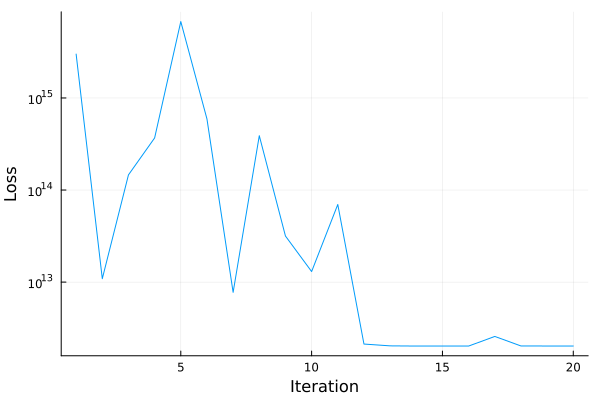

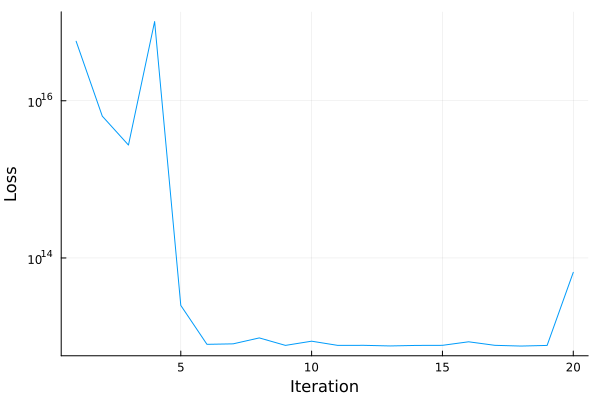

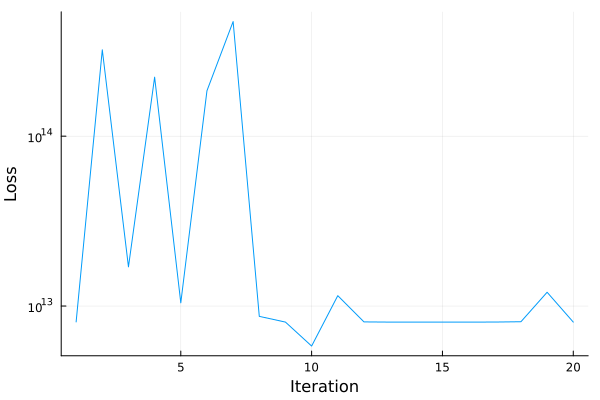

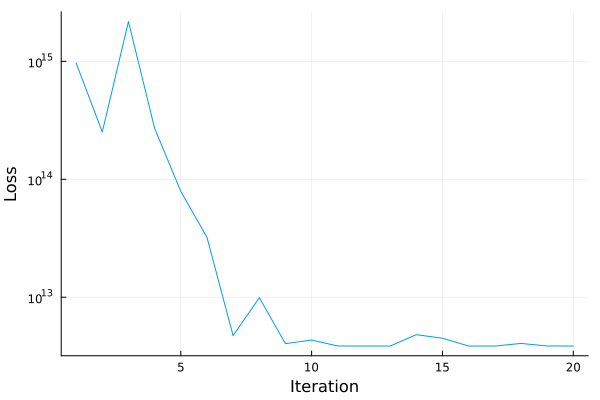

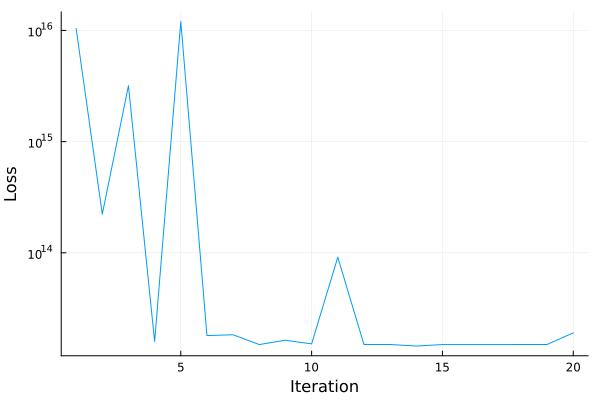

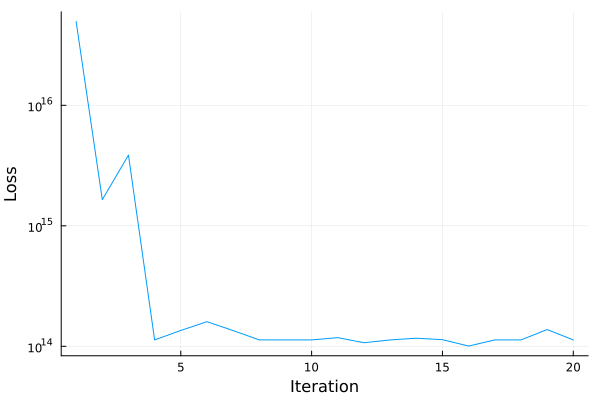

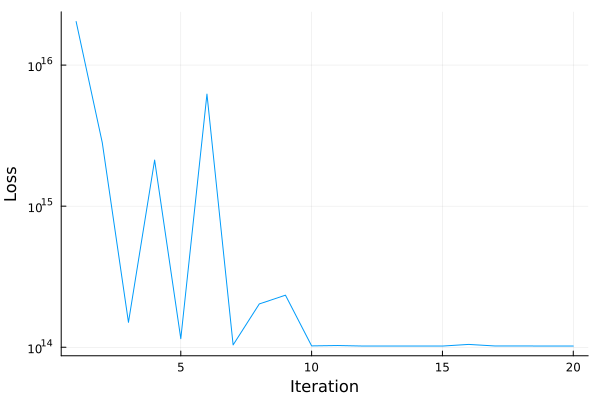

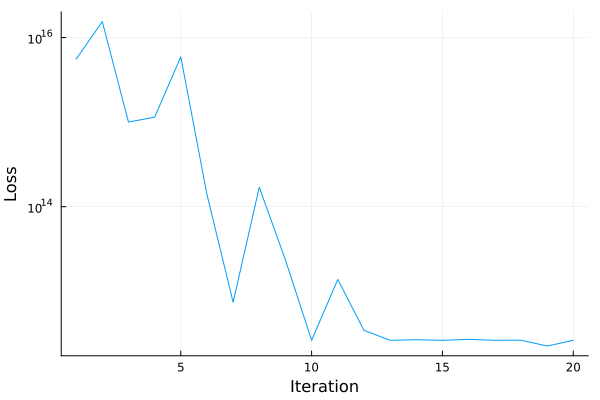

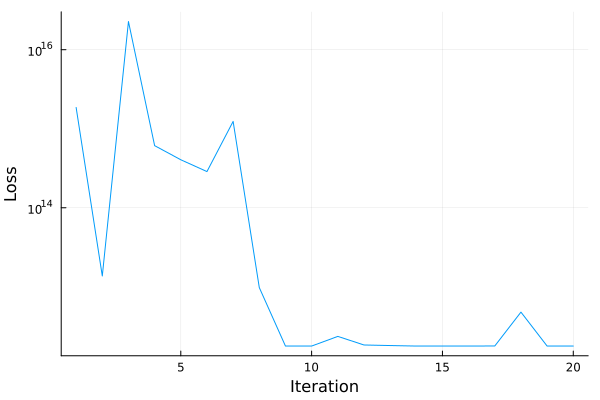

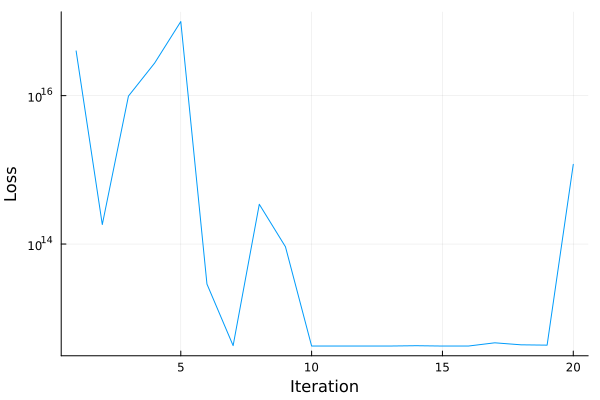

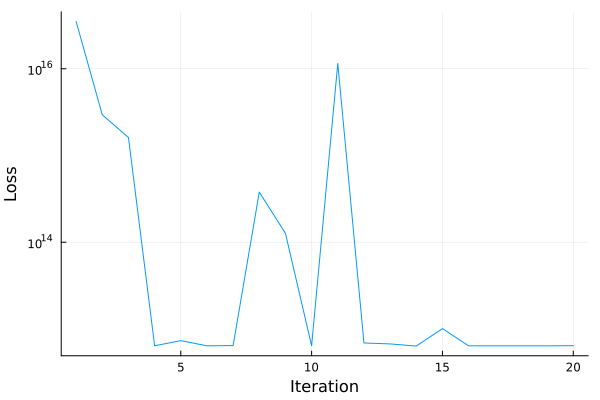

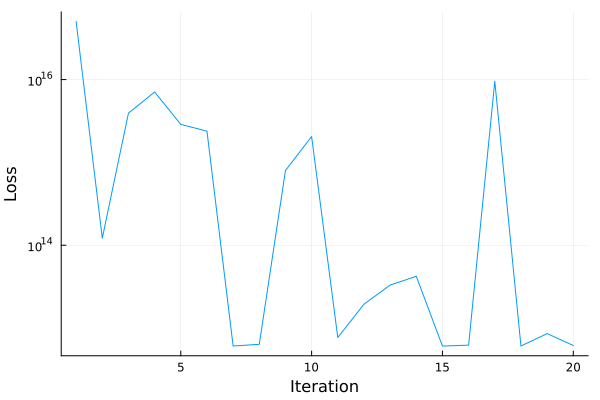

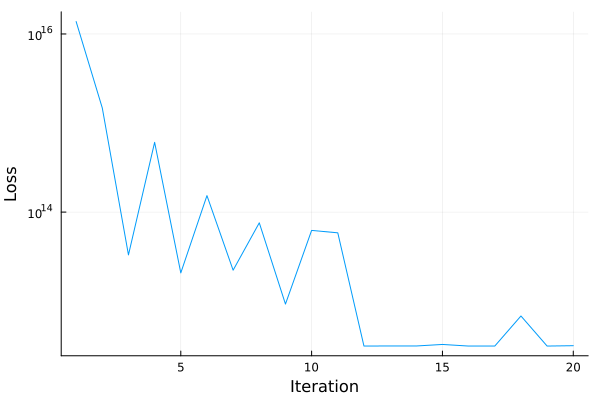

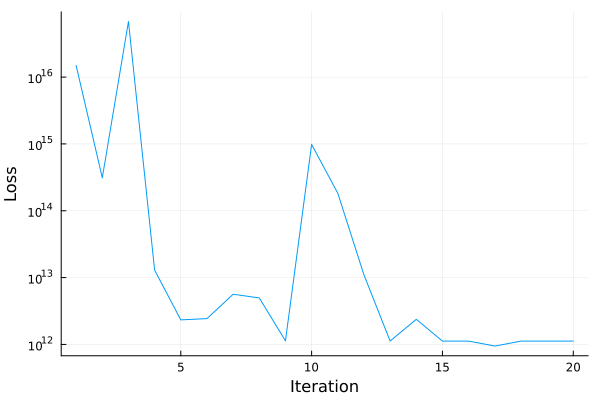

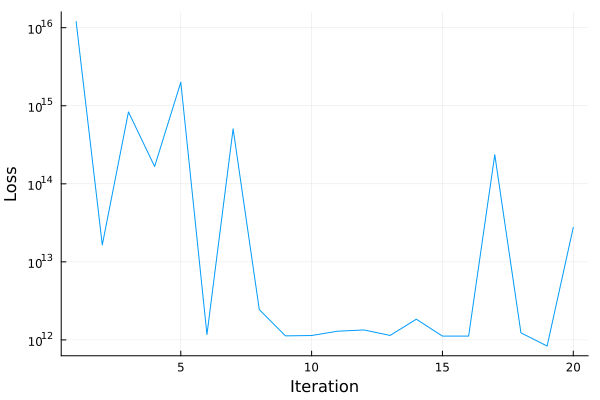

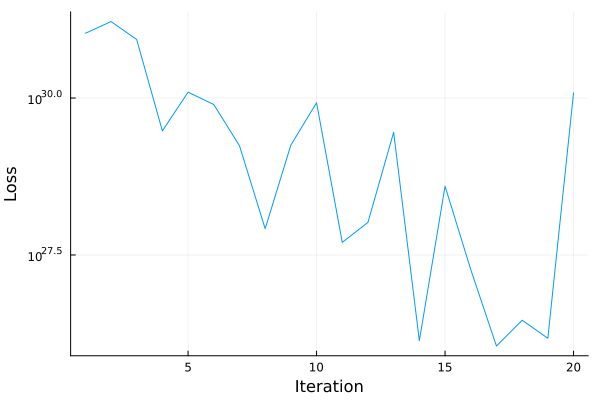

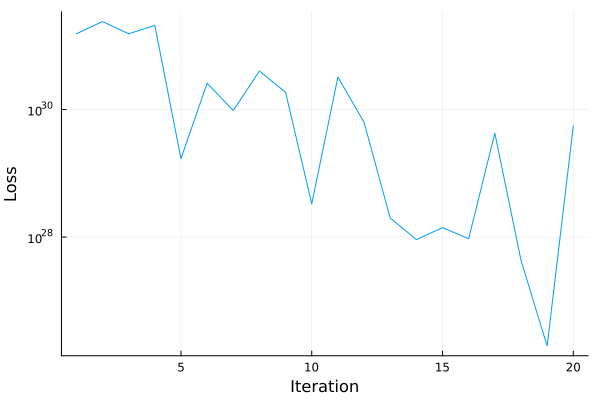

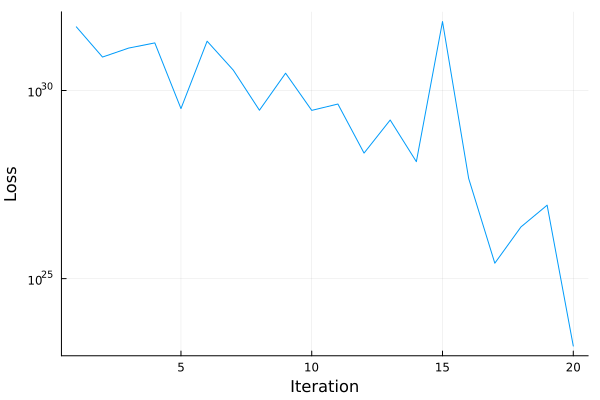

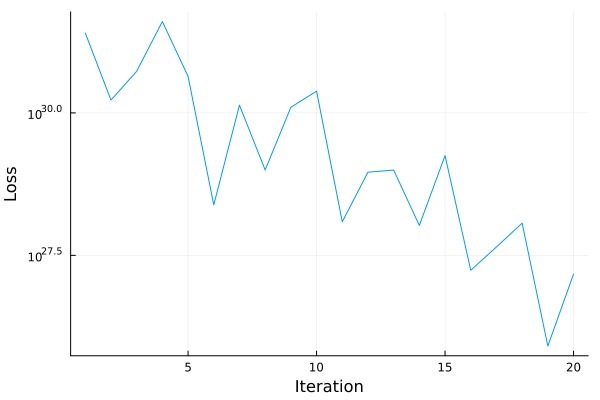

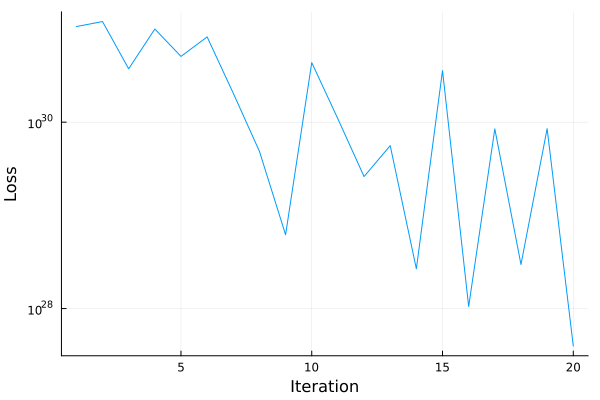

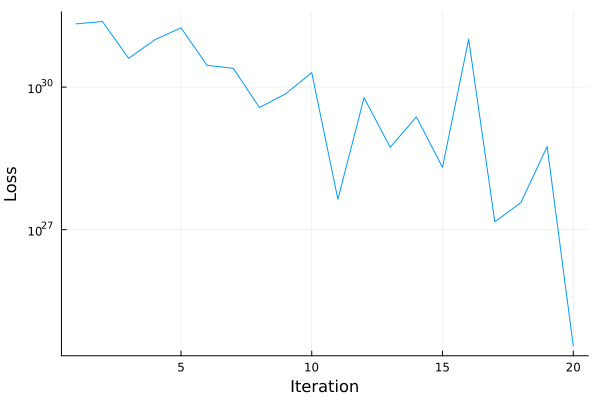

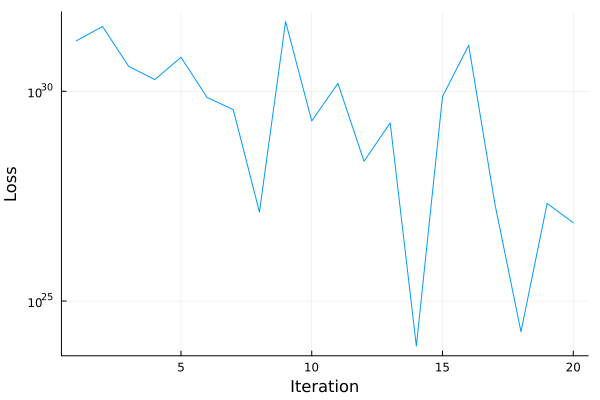

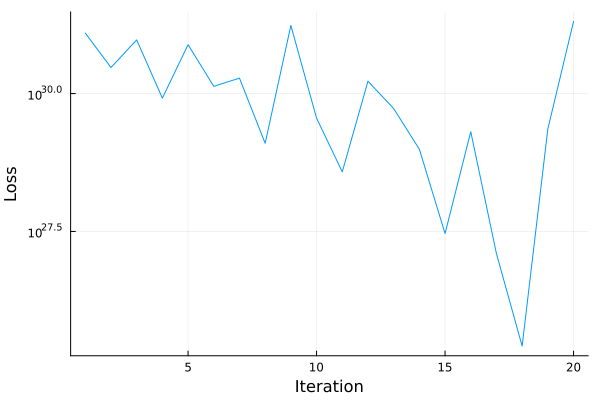

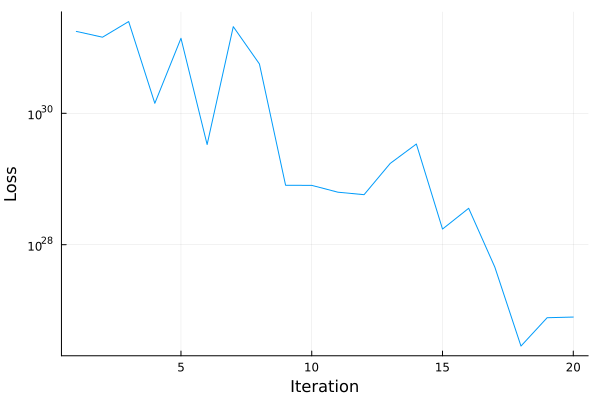

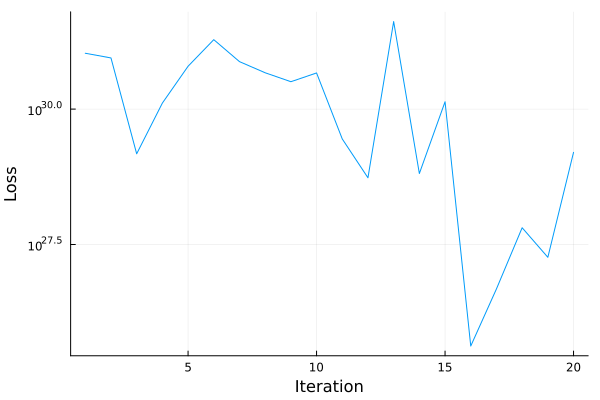

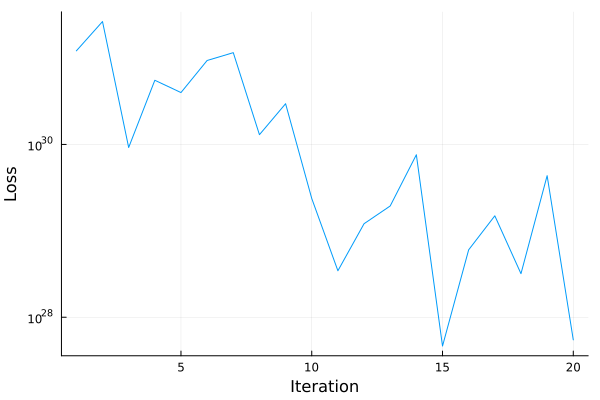

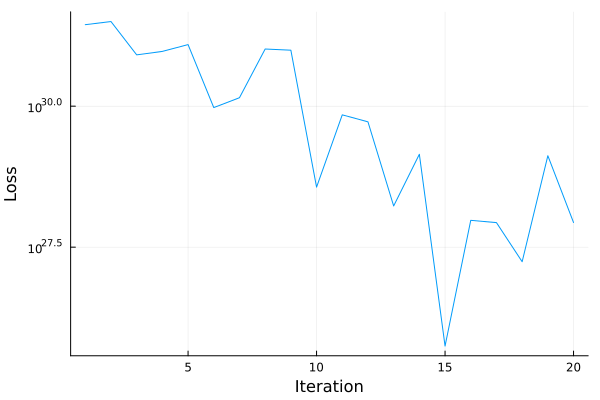

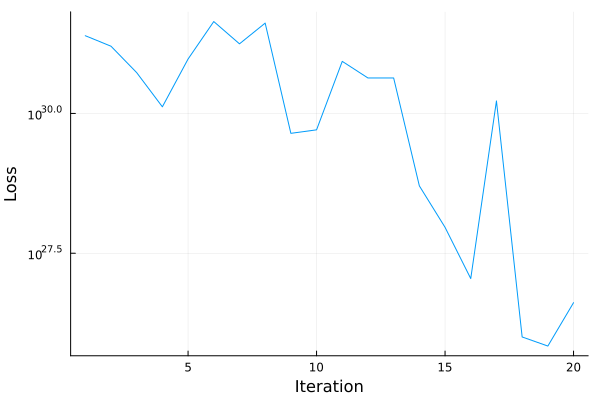

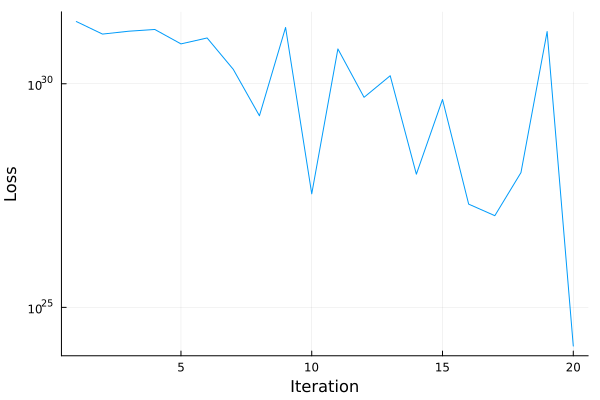

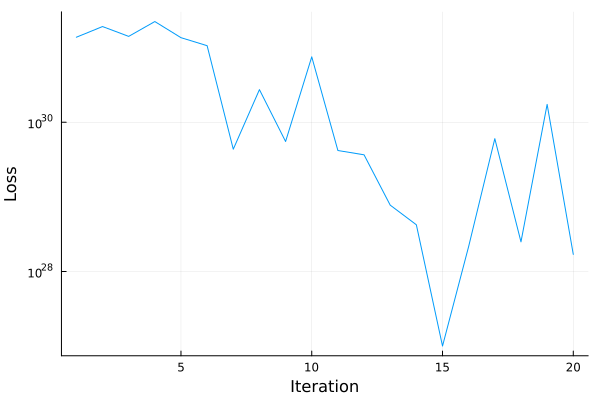

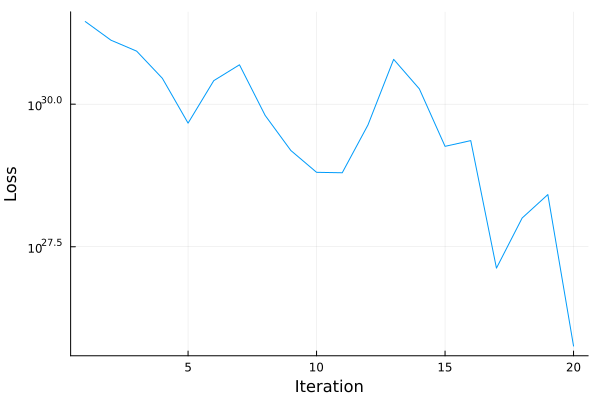

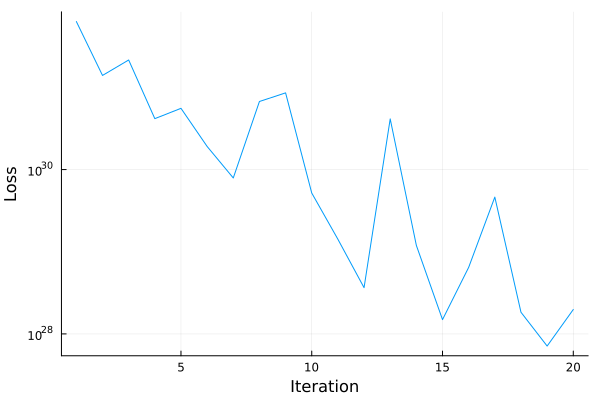

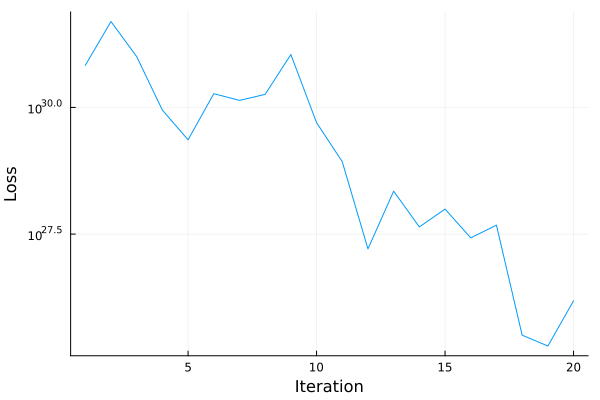

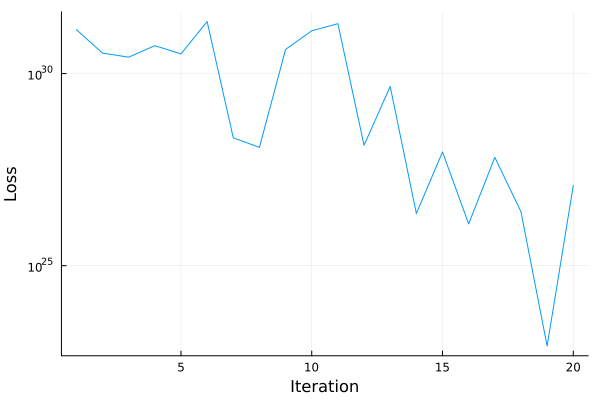

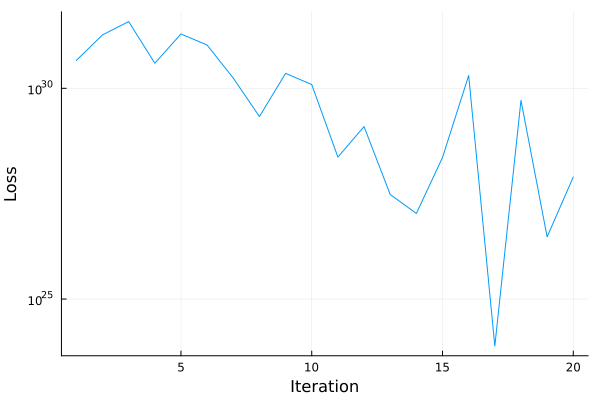

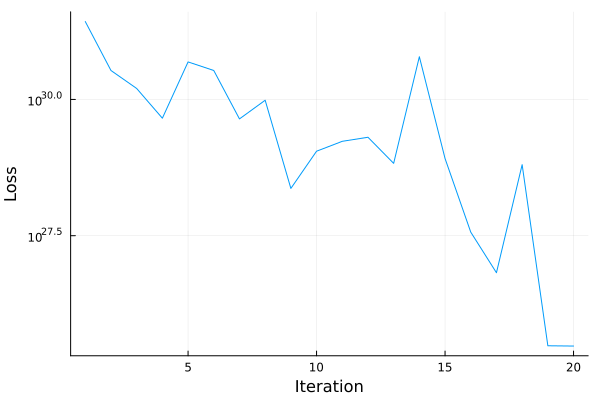

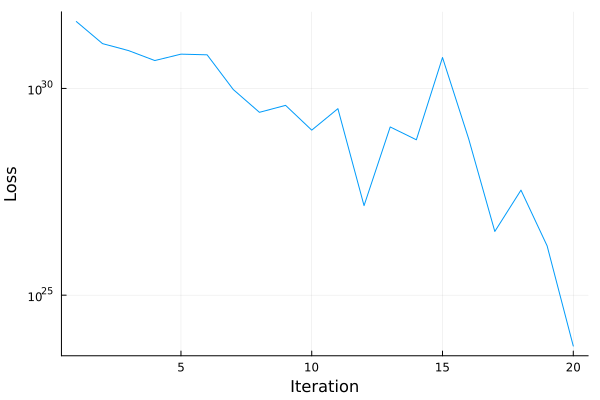

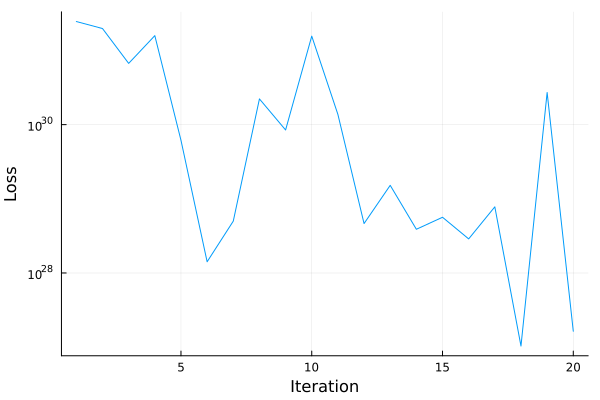

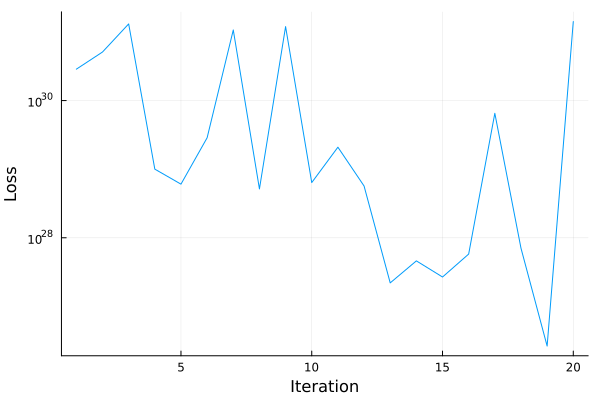

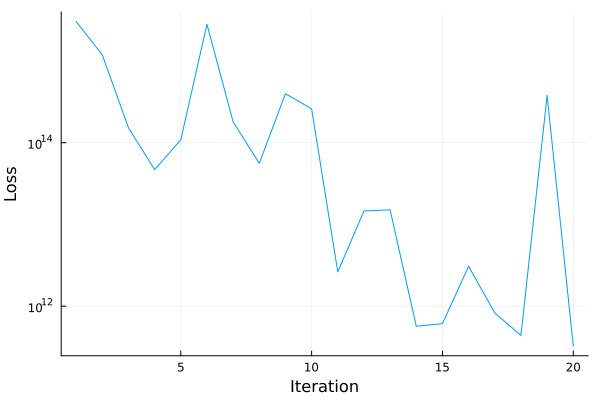

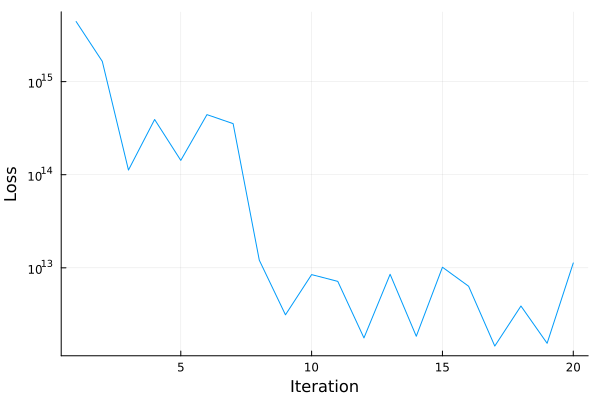

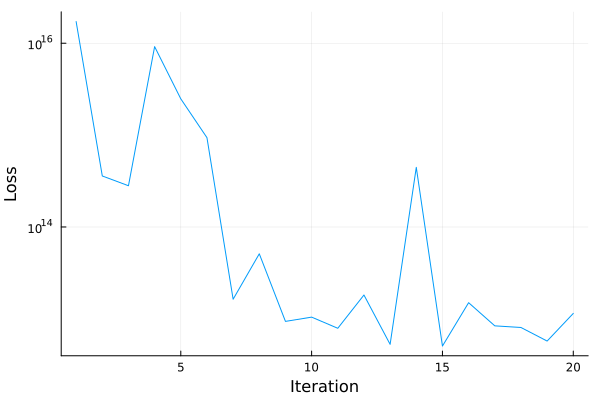

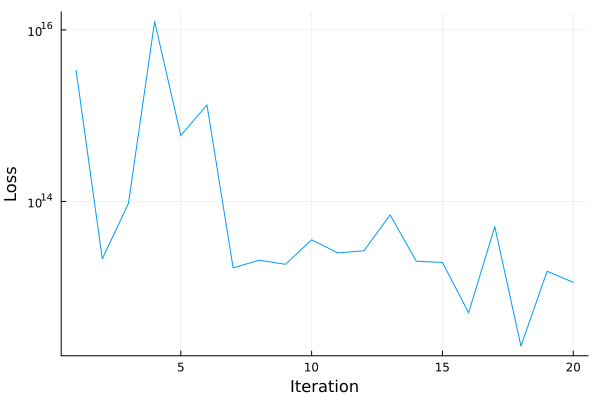

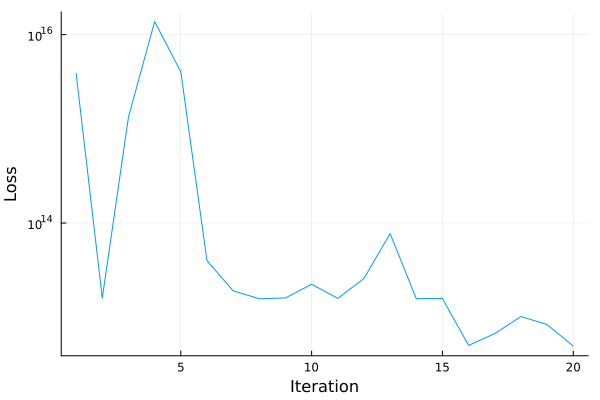

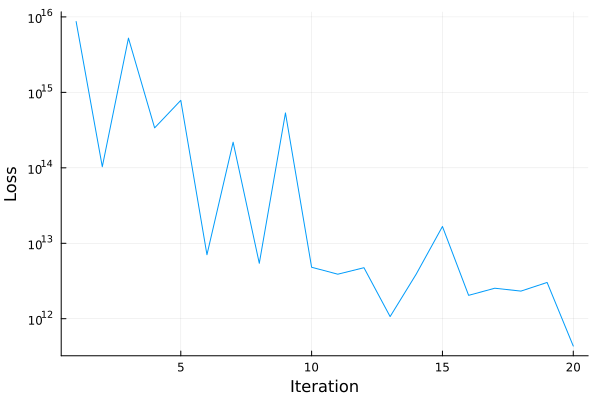

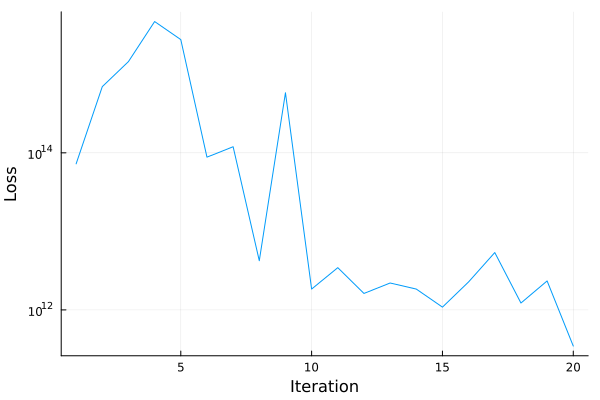

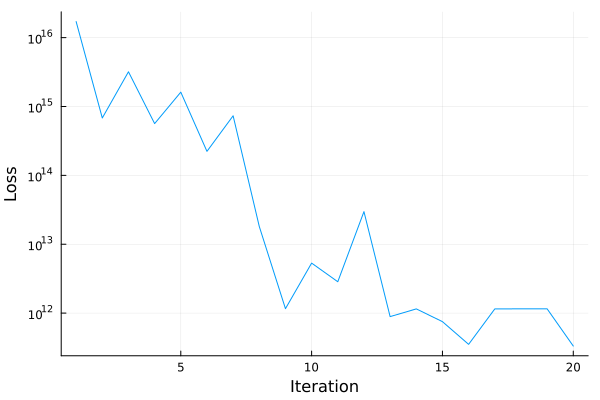

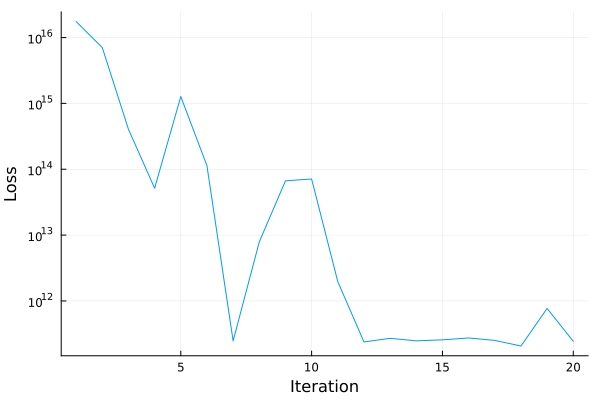

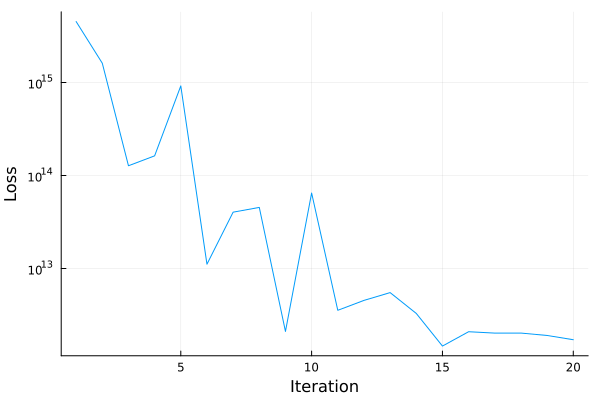

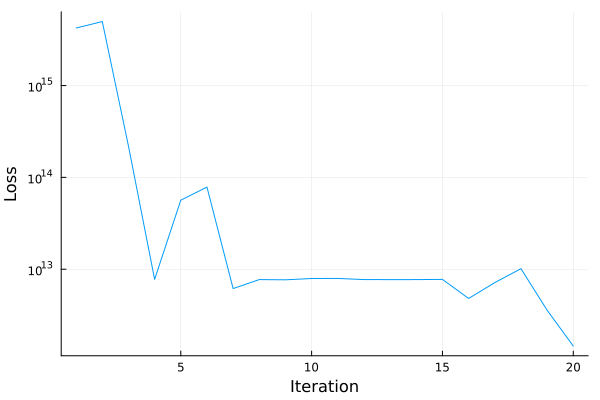

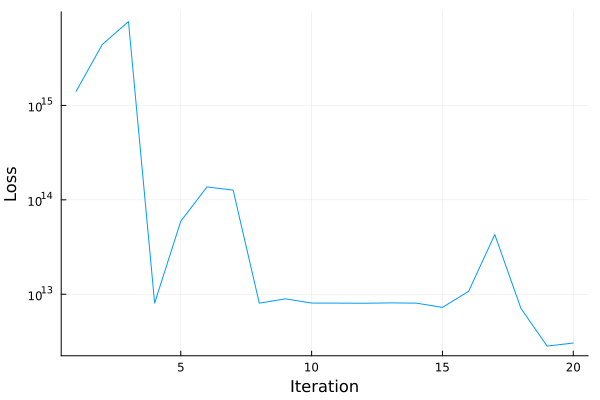

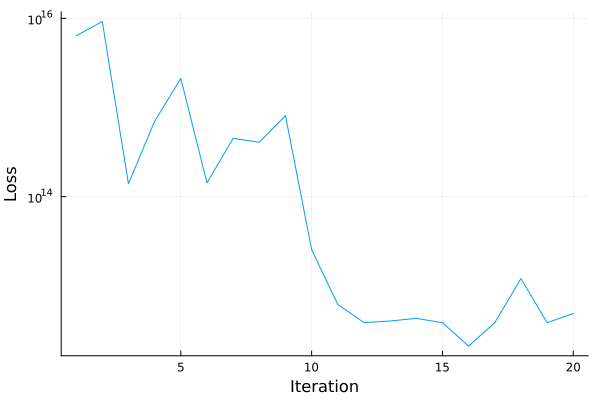

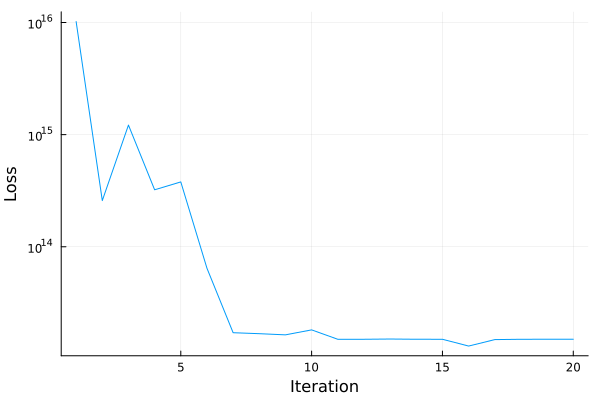

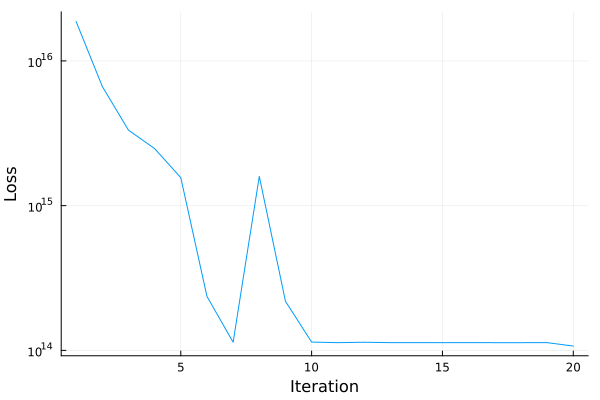

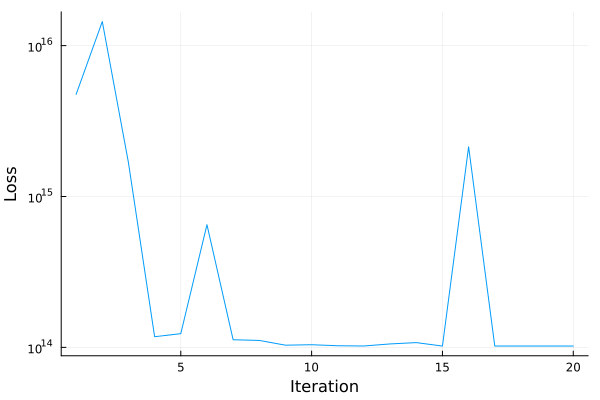

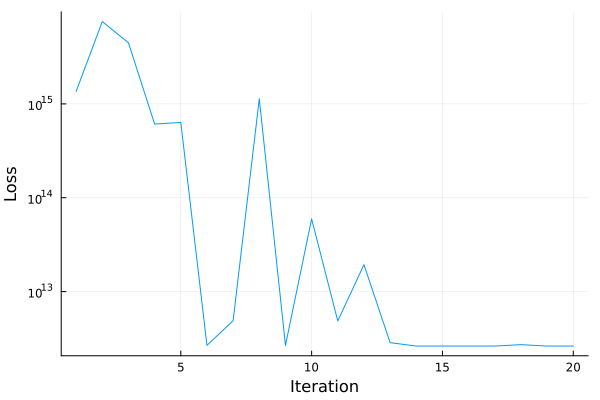

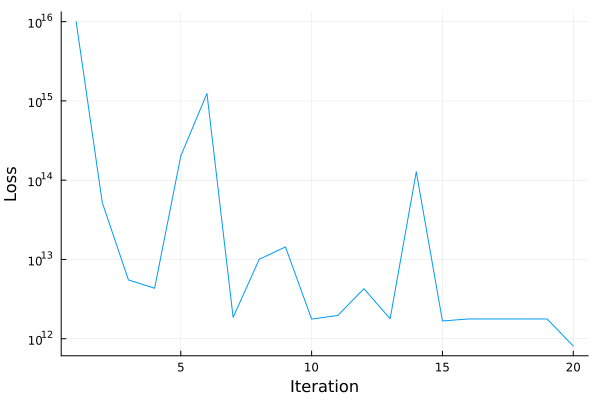

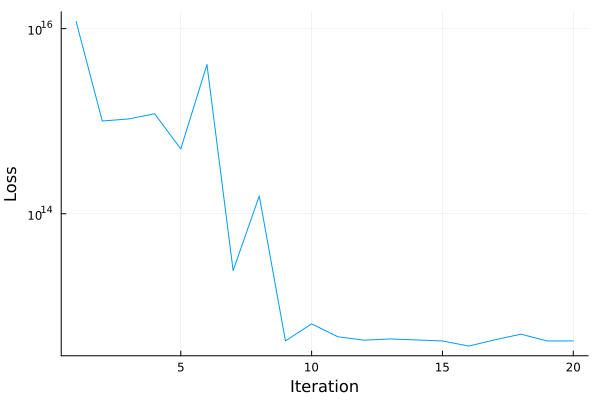

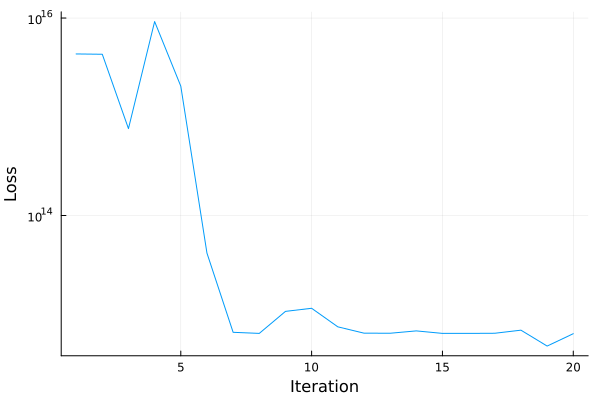

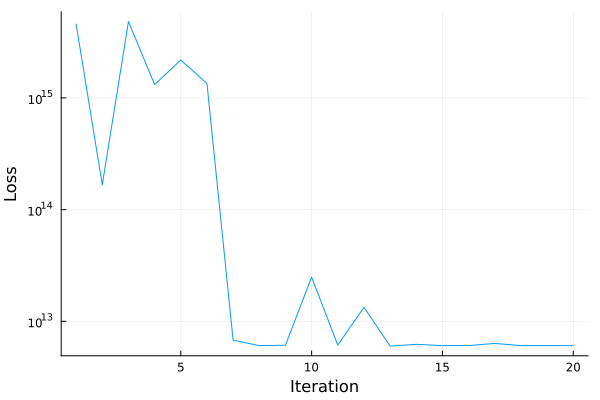

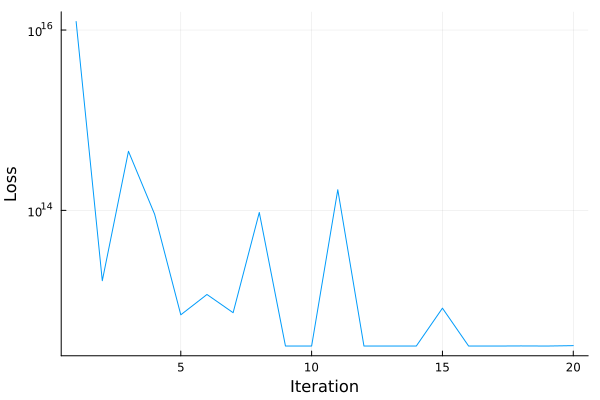

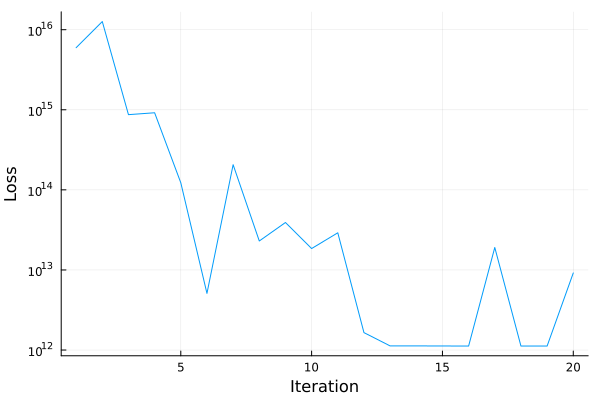

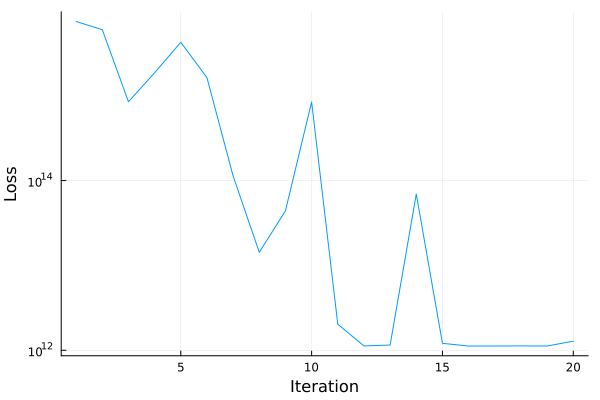

3-element Vector{DataFrame}:
 24×40 DataFrame
 Row │ Susceptible  Infected   Diagnosed  Ailing     Recognized  Healed     Th ⋯
     │ Float64      Float64    Float64    Float64    Float64     Float64    Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   2.95347e7  5.46518e6  3.02824e7  9.58399e7   1.12077e7  7.4204e7    5 ⋯
   2 │   1.04016e6  7.7498e7   9.66136e7  6.54805e6   1.62944e7  9.4906e7    6
   3 │   3.45132e7  8.36676e7  2.15353e7  6.91759e7   3.43733e7  1.79131e7   3
   4 │   1.16202e7  8.26445e7  1.91273e7  8.01581e7   8.86939e7  2.40023e7   9
   5 │   8.75908e6  3.13978e7  3.39904e7  9.09097e7   4.69928e7  9.22401e7   5 ⋯
   6 │   8.44276e7  1.38594e7  2.41191e7  1.08573e7   8.10617e7  3.97528e6   6
   7 │   5.92245e7  9.08372e7  2.82812e7  9.86292e7   8.45867e7  2.00953e7   4
   8 │   8.78539e7  4.01491e7  3.01526e7  1.56932e7   3.95592e7  8.42286e7   3
  ⋮  │      ⋮           ⋮          ⋮          ⋮          ⋮           ⋮     

In [102]:
# now multiple models 
odeprobs = [ODEProblem(sys, [], extrema(all_ts)) for sys in syss];
ensemble_fits = global_ensemble_fit(odeprobs, train_dfs, mapping; maxiters=2000) # 2000 for speed, the API can parallelize, so I won't do it here
losses, ensemble_remade_probs, ensemble_sols = calculate_losses_and_solutions(ensemble_fits, odeprobs, dfs);
fitdfs = [fitvec_to_df(fit, all_syms[i]) for (i, fit) in enumerate(ensemble_fits)]

In [103]:
forecast_plts = [forecast_plot(df, ensemble_sol) for ensemble_sol in ensemble_sols]

3-element Vector{Plots.Plot{Plots.GRBackend}}:
 Plot{Plots.GRBackend() n=6}
 Plot{Plots.GRBackend() n=6}
 Plot{Plots.GRBackend() n=6}

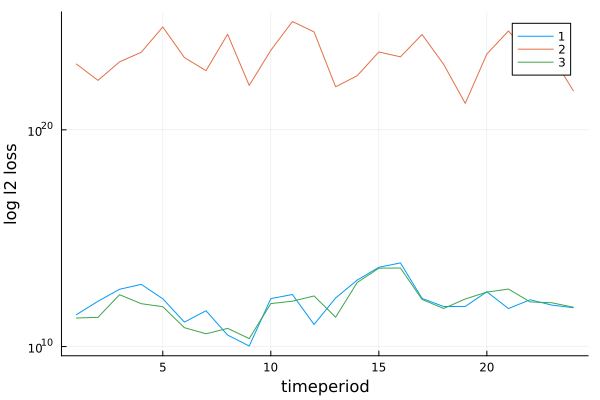

In [104]:
# this plot shows that the second model consistently underperforms 
ensemble_loss_plot(losses)

In [113]:
dfi = dfs[1]
prbs = ensemble_remade_probs[:, 1]
# optimize linear conbination weights for the ensemble for first timeperiod
weights = optimize_ensemble_weights(prbs, dfi.t, Matrix(dfi[:, 2:end]); maxiters=1000)

u: 3-element Vector{Float64}:
 0.00241856823437817
 0.003315816894656782
 0.009954324895196072

In [106]:
# interface for solving collections of models at a time, used to do the second phase of optimization
eprob = EnsembleProblem(prbs; prob_func=(probs, i, reset) -> probs[i])
esol = solve(eprob; trajectories=length(prbs), saveat=dfi.t)

EnsembleSolution Solution of length 3 with uType:
ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Vector{Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.Fun

In [107]:
all_weights = [optimize_ensemble_weights(prbs, dfi.t, Matrix(dfi[:, 2:end]); maxiters=1000) for (dfi, prbs) in zip(dfs, eachcol(ensemble_remade_probs))]
weights_df = DataFrame(stack(map(x -> x.u, all_weights))', :auto)

24×3 DataFrame
 Row │ x1           x2           x3          
     │ Float64      Float64      Float64     
─────┼───────────────────────────────────────
   1 │ 0.0025434    0.00328666   0.00896981
   2 │ 5.94067e-5   0.0135092    4.35389e-5
   3 │ 0.00018369   0.00465475   0.00837989
   4 │ 0.000609914  0.00944587   0.0169821
   5 │ 0.00233115   0.0035047    0.00619664
   6 │ 0.000723742  0.00746556   0.00011067
   7 │ 0.00239488   0.000488537  0.00189156
   8 │ 0.00351869   0.00318538   0.00321393
  ⋮  │      ⋮            ⋮            ⋮
  18 │ 0.000283558  0.00112039   0.00773619
  19 │ 0.00129132   0.000720847  0.00652918
  20 │ 0.000846332  0.000171008  0.00605366
  21 │ 0.00054223   0.00380937   0.0057894
  22 │ 0.00188168   0.000306407  0.00110274
  23 │ 7.12452e-5   0.0104967    0.000371494
  24 │ 0.000628462  4.66517e-8   0.00349028
                               9 rows omitted

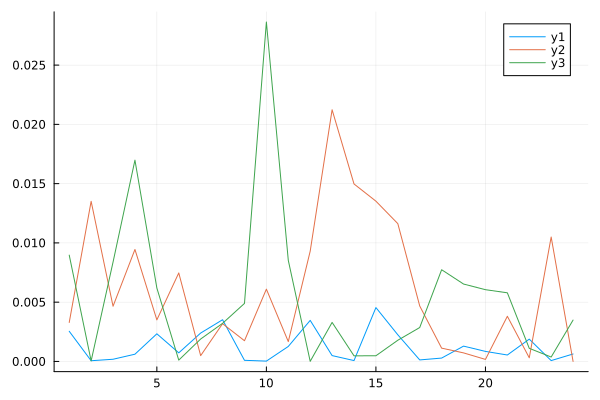

In [115]:
# see if the weights are consistent over time (which is consistent with ensemble_loss_plot(losses) above)
plt = plot()
plot!(plt, weights_df.x1);
plot!(plt, weights_df.x2);
plot!(plt, weights_df.x3);
display(plt)

6. Assess consistency of the ensemble by tracking the smoothness/continuity of the ensemble weights across the time periods of interest. (plots from page 1, and bar plot)

In [117]:
weighted_ensemble_df = build_weighted_ensemble_df(weights, esol)

20×4 DataFrame
 Row │ t      deaths     hosp            cases          
     │ Int64  Float64    Float64         Float64        
─────┼──────────────────────────────────────────────────
   1 │     0  6.01148e5  185294.0             4.04513e5
   2 │     1  6.04372e5       1.04936e5  199989.0
   3 │     2  6.05915e5   51872.3         95939.4
   4 │     3  6.06624e5   23968.3         46861.5
   5 │     4  6.06944e5   10659.9         24575.4
   6 │     5  6.07088e5    4644.61        14595.5
   7 │     6  6.07155e5    2008.73        10064.1
   8 │     7  6.07188e5     877.339        7902.02
  ⋮  │   ⋮        ⋮            ⋮               ⋮
  14 │    13  6.07248e5      43.8127       4494.65
  15 │    14  6.07254e5      38.7258       4201.94
  16 │    15  6.07259e5      35.2413       3929.8
  17 │    16  6.07264e5      32.5191       3675.91
  18 │    17  6.07269e5      30.2024       3438.69
  19 │    18  6.07273e5      28.1369       3216.81
  20 │    19  6.07277e5      26.2541       3009.43
                                          5 rows omitted

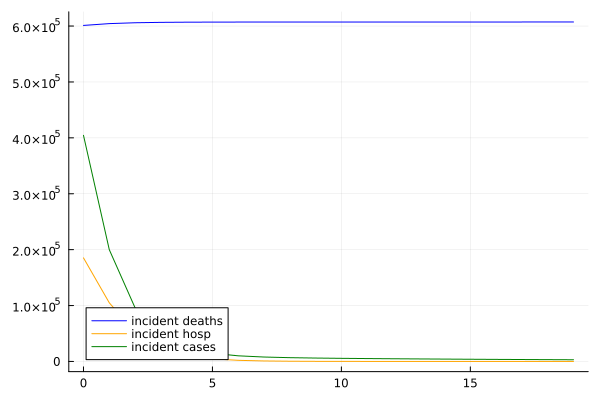

In [121]:
display(plot_covidhub(weighted_ensemble_df))

7. Build and run a forecast simulator
    * Select the alignment/map from 
    * Select the ensemble model from 
    * Select the calibrated parameter output from 
    * Select the time points of the forecast horizon 
    * forecast(calibrated 4, df), forecast(4, df, calibrationmap)
    * ensemble_forecast(4, df, map, weights)


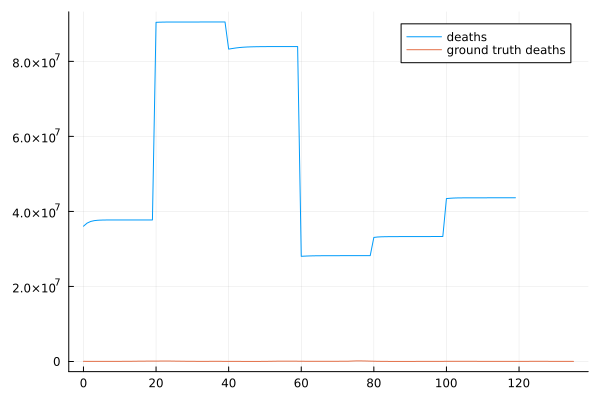

In [124]:
# ensemble_remade_probs, ensemble_sols
model1_df, model1_obs = forecast_stitch(df, ensemble_sols[1][1:4:end])
plot(model1_df.timestamp, model1_obs[:, 1]; label="deaths")
plot!(df.t, df.deaths; label="ground truth deaths")

In [125]:
model1_df

120×9 DataFrame
 Row │ timestamp  Susceptible(t)  Infected(t)   Diagnosed(t)   Ailing(t)       ⋯
     │ Float64    Float64         Float64       Float64        Float64         ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │       0.0    2.95347e7       5.46518e6       3.02824e7      9.58399e7   ⋯
   2 │       1.0   -1.74862e-27     2.69315e7       1.30286e7      3.00721e7
   3 │       2.0   -1.07939e-29     2.07225e7       5.6148e6       9.41621e6
   4 │       3.0   -2.75384e-32     1.59449e7       2.43057e6      2.94958e6
   5 │       4.0    5.94638e-34     1.22686e7       1.06021e6      9.2462e5    ⋯
   6 │       5.0    2.49856e-37     9.44007e6       4.69203e5      2.9167e5
   7 │       6.0   -4.32459e-39     7.26355e6       2.12515e5  93064.8
   8 │       7.0    8.90262e-44     5.58891e6   99967.0        30599.5
  ⋮  │     ⋮            ⋮              ⋮              ⋮               ⋮        ⋱
 114 │     113.0    9.99652e-123    4.90299         7.44484e7      0.134623    ⋯
 115 │     114.0    3.09904e-129    1.35539         7.06115e7      0.0372059
 116 │     115.0    1.06027e-135    0.374673        6.69723e7      0.0102836
 117 │     116.0    5.71881e-142    0.103557        6.35206e7      0.00284214
 118 │     117.0    4.59891e-148    0.0286157       6.02469e7      0.000785345 ⋯
 119 │     118.0    2.33217e-154    0.00790642      5.71419e7      0.000216985
 120 │     119.0   -1.75791e-160    0.00218099      5.41969e7      5.9855e-5
                                                  4 columns and 105 rows omitted